In [2]:
import torch
import torch.nn as nn
import numpy as np
import copy

from vn1forecasting.dualt import (
    DataPreprocessor, 
    generate_time_series_samples, prepare_batch_data, plot_predictions_vs_actual_with_price,
    validate_model_with_loss, MultiTimeSeriesTransformer, run_inference_on_test, save_predictions_in_custom_format
)

In [3]:
# Set the device to MPS (Metal Performance Shaders) if available; otherwise, fallback to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
preprocessor = DataPreprocessor()
preprocessed_df = preprocessor.preprocess_data()

In [6]:
preprocessed_df.head(196).tail(20)

,Client,Warehouse,Product,Date,Sales,use,Price,rolling_4w_sales,rolling_13w_sales
176,0,1,281,2023-11-20,0.000000,train,NaN,0.002044,0.004823
177,0,1,281,2023-11-27,0.000000,train,NaN,0.001362,0.004823
178,0,1,281,2023-12-04,0.105068,train,0.900035,0.000000,0.004478
179,0,1,281,2023-12-11,0.000000,train,NaN,0.000000,0.004478
180,0,1,281,2023-12-18,0.000000,train,NaN,0.000000,0.004478
181,0,1,281,2023-12-25,0.000000,train,NaN,0.000000,0.004478
182,0,1,281,2024-01-01,0.000000,train,NaN,0.000000,0.002067
183,0,1,281,2024-01-08,0.000000,test,NaN,NaN,0.002067
184,0,1,281,2024-01-15,0.105068,test,NaN,NaN,0.001722
185,0,1,281,2024-01-22,0.210135,test,NaN,0.000000,0.001722


<Axes: xlabel='Date'>

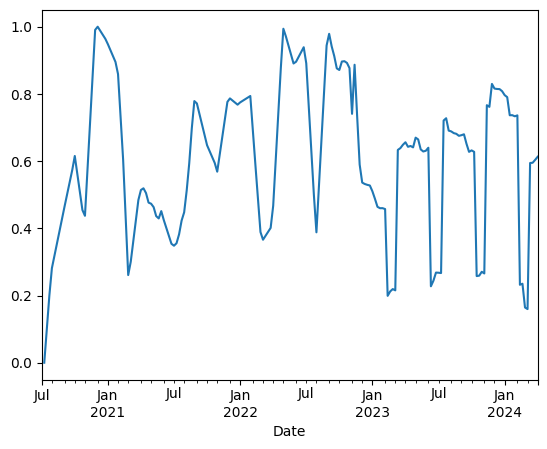

In [7]:
preprocessed_df.loc[
    (preprocessed_df.Client==0)&
    (preprocessed_df.Warehouse==3)&
    (preprocessed_df.Product==897)
].set_index('Date').rolling_13w_sales.plot()

<Axes: >

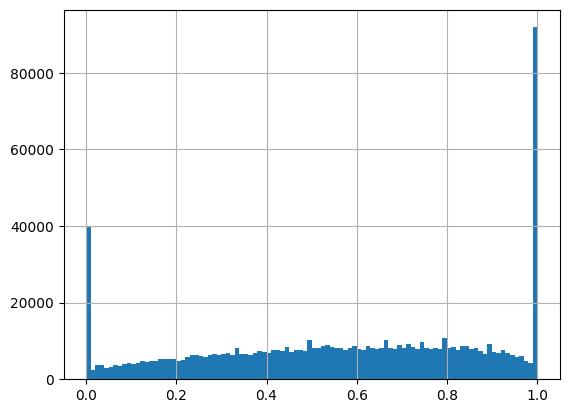

In [8]:
preprocessed_df.Price.hist(bins=100)

<Axes: >

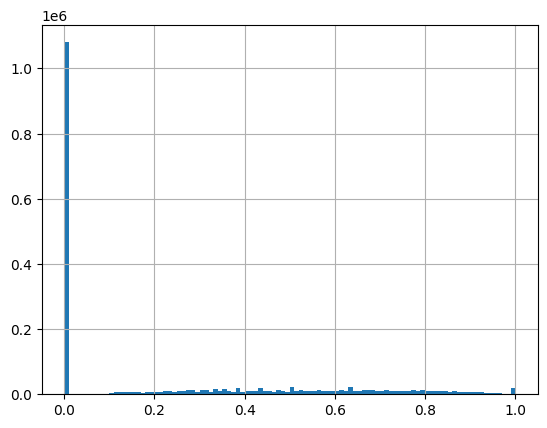

In [9]:
preprocessed_df.Sales.hist(bins=100, range=(0,1))

In [10]:
preprocessed_df.Sales.min(), preprocessed_df.Sales.max()

(np.float64(-1.4728859397362333), np.float64(3.4649735207179266))

In [11]:
# Generate train and validation samples
n_samples = 20  # Number of samples to generate
train_samples, valid_samples = generate_time_series_samples(preprocessed_df, n_samples)
train_samples[0]['sales'], train_samples[0]['price'], train_samples[0]['target']

(array([0.8805748 , 0.87556495, 0.84551943, 0.80661378, 0.77572454,
        0.73411705, 0.78787271, 0.73919032, 0.8805748 , 0.88303352,
        0.85132805, 0.8805748 , 0.94905569, 0.93447592, 0.93822152,
        0.89257739, 0.94905569, 1.        , 0.93822152, 0.85973698,
        0.94006838, 0.8678072 , 0.86246333, 0.83647804, 0.68811414,
        0.84551943, 0.80300317, 0.72891199, 0.76279209, 0.77150578,
        0.84551943, 0.6604311 , 0.87042663, 0.71807782, 0.6604311 ,
        0.62830109, 0.57918261, 0.54264839, 0.71243284, 0.51397335,
        0.60029511, 0.52882336, 0.60029511, 0.49793412, 0.54264839,
        0.61007185, 0.59001678, 0.54264839, 0.62830109, 0.61007185,
        0.6604311 , 0.71243284]),
 array([0.33148437,        nan, 0.32138268, 0.35617439, 0.36707316,
        0.36682987,        nan,        nan, 0.26571117, 0.25346323,
               nan, 0.29941321,        nan, 0.35143322, 0.34334494,
        0.35195165, 0.36217711,        nan, 0.37282882, 0.39256715,
        0.3935

In [12]:
batch_data = prepare_batch_data(train_samples, mode='train')
sales, price, decoder_input, wom, woy, moy, qoy, sales_padding_mask, price_padding_mask, price_validity_mask, target, client, warehouse, product, rolling_4w_sales, rolling_13w_sales = batch_data
price_padding_mask[0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
# Model Initialization
model = MultiTimeSeriesTransformer(
    input_dim=1,
    d_model=64,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    num_wom=5,
    num_woy=53,
    num_moy=12,
    num_qoy=4,
    date_embedding_dim=3,
    num_clients=len(preprocessor.client_encoder.classes_),
    num_warehouses=len(preprocessor.warehouse_encoder.classes_),
    num_products=len(preprocessor.product_encoder.classes_),
    category_embedding_dim=16,
    dropout=0.1
)

/Users/senoni/noni/vn1/env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [15]:
model = model.to(device)

In [16]:
def freeze_module_by_name(model, module_name_substring):
    """
    Freeze all parameters whose name contains 'module_name_substring'.
    i.e., param.requires_grad = False
    """
    for name, param in model.named_parameters():
        if module_name_substring in name:
            param.requires_grad = False

def unfreeze_module_by_name(model, module_name_substring):
    """
    Unfreeze all parameters whose name contains 'module_name_substring'.
    i.e., param.requires_grad = True
    """
    for name, param in model.named_parameters():
        if module_name_substring in name:
            param.requires_grad = True

In [17]:
for phase, n_epochs, batch_size, n_samples, lr in [
    ('init', 1, 24, 50000, 1e-3),
    ('core', 51, 512, 200000, 1e-3),
    ('core', 51, 512, 1, 1e-4),
    ('core', 51, 512, 1, 1e-5),
    ('tune', 51, 512, 200000, 1e-5),
    ('finish', 51, 512, 200000, 1e-5)
]:
    loss_fn = nn.MSELoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # ---------------------------------------------------------------------------
    # 1) Phase-Specific Freezing
    # ---------------------------------------------------------------------------
    if phase == 'tune':
        # Freeze all embeddings: 
        freeze_module_by_name(model, 'embedding')
        freeze_module_by_name(model, 'sales_encoder')
        print("Froze all embedding layers.")
        print("Froze the sales encoder.")

    if phase == 'finish':
        # Freeze the price encoder:
        freeze_module_by_name(model, 'price_encoder')
        unfreeze_module_by_name(model, 'sales_encoder')
        print("Froze the price encoder.")
        print("Unfroze the sales encoder.")

    # ---------------------------------------------------------------------------
    # 2) Sample Generation
    # ---------------------------------------------------------------------------
    if phase in ['init', 'tune', 'finish']:
        train_samples, valid_samples = [], []
    _train_samples, _valid_samples = generate_time_series_samples(
        preprocessed_df, n_samples, train_valid_split=0.8, phase=phase
    )
    train_samples += _train_samples
    valid_samples += _valid_samples
    print(f"Training samples: {len(train_samples)}")

    # Initialize early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    patience_counter = 0
    
    # ---------------------------------------------------------------------------
    # 3) Train/Eval Loop for this Phase
    # ---------------------------------------------------------------------------
    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0

        # Shuffle train samples
        np.random.shuffle(train_samples)

        # Process training batches
        for i in range(0, len(train_samples), batch_size):
            # Prepare batch data
            batch_samples = train_samples[i:i + batch_size]
            batch_data = prepare_batch_data(batch_samples, mode='train', device=device)
            (sales, price, decoder_input, wom, woy, moy, qoy,
             sales_padding_mask, price_padding_mask, price_validity_mask,
             client, warehouse, product, target, rolling_4w_sales,
             rolling_13w_sales) = batch_data

            # Forward pass
            predictions = model(
                sales, price, decoder_input, wom, woy, moy, qoy,
                sales_padding_mask, price_padding_mask, price_validity_mask,
                client, warehouse, product, rolling_4w_sales, rolling_13w_sales
            ).squeeze(-1)

            # Compute loss
            loss = model.masked_loss(predictions, target, loss_fn)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation
        val_loss, val_predictions, val_targets = validate_model_with_loss(
            model, valid_samples, batch_size=batch_size, loss_fn=loss_fn, device=device
        )
        print(f"Epoch {epoch}, Train Loss: {total_train_loss / (len(train_samples) // batch_size):.4f}, "
              f"Validation Loss: {val_loss:.4f}")

        # Additional metrics (MSE, MAE)
        valid_mask = ~np.isnan(val_targets)
        val_mse = np.mean((val_predictions[valid_mask] - val_targets[valid_mask]) ** 2)
        val_mae = np.mean(np.abs(val_predictions[valid_mask] - val_targets[valid_mask]))
        print(f"Validation MSE: {val_mse:.4f}")
        print(f"Validation MAE: {val_mae:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs - no val loss improvement for {patience} epochs")
            model.load_state_dict(best_model_state)
            break

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr:.2e}")

    # Ensure best model for next phase
    model.load_state_dict(best_model_state)


Training samples: 11659
Epoch 0, Train Loss: 0.0676, Validation Loss: 0.0398
Validation MSE: 0.0397
Validation MAE: 0.1470
Current learning rate: 1.00e-03
Training samples: 169989
Epoch 0, Train Loss: 0.0433, Validation Loss: 0.0414
Validation MSE: 0.0413
Validation MAE: 0.1330
Current learning rate: 1.00e-03
Epoch 1, Train Loss: 0.0343, Validation Loss: 0.0296
Validation MSE: 0.0295
Validation MAE: 0.1018
Current learning rate: 1.00e-03
Epoch 2, Train Loss: 0.0272, Validation Loss: 0.0253
Validation MSE: 0.0253
Validation MAE: 0.0903
Current learning rate: 1.00e-03
Epoch 3, Train Loss: 0.0235, Validation Loss: 0.0281
Validation MSE: 0.0281
Validation MAE: 0.1000
Current learning rate: 1.00e-03
Epoch 4, Train Loss: 0.0222, Validation Loss: 0.0231
Validation MSE: 0.0231
Validation MAE: 0.0845
Current learning rate: 1.00e-03
Epoch 5, Train Loss: 0.0216, Validation Loss: 0.0263
Validation MSE: 0.0262
Validation MAE: 0.0943
Current learning rate: 1.00e-03
Epoch 6, Train Loss: 0.0213, Valid

In [18]:
#preprocessed_df.loc[preprocessed_df.Product==1293]

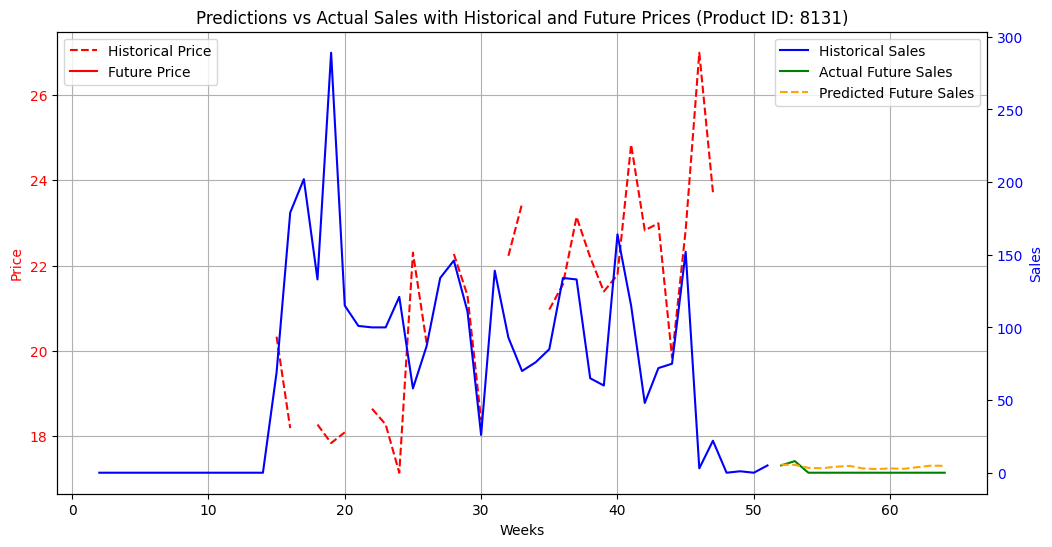

In [37]:
# Select a sample from validation data
sample_index = 7
sample = valid_samples[sample_index]  # Replace 0 with the desired index

# Plot predictions vs actuals
plot_predictions_vs_actual_with_price(
    sample=sample,
    scalers=preprocessor.normalization_params,  # Access the normalization scalers
    preprocessor=preprocessor,  # Pass the preprocessor for inverse_transform
    val_predictions=val_predictions[sample_index],  # Optional, if not already in sample
    val_targets=val_targets[sample_index]  # Optional, if not already in sample
)


In [20]:
sample

{'sales': array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.65853857, 0.51244261, 0.55652966,
        0.68579725, 0.68579725, 0.79295945, 0.55652966, 0.71068248,
        0.39647973, 0.59471959, 0.39647973, 0.82664536, 0.79295945,
        1.        , 0.55652966]),
 'price': array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        n

In [21]:
# Generate test samples
test_samples = generate_time_series_samples(
    preprocessed_df,
    mode='test'
)


In [22]:
len(test_samples)

15053

In [23]:
test_samples[0]

{'sales': array([0.        , 0.16652843, 0.21013548, 0.16652843, 0.10506774,
        0.16652843, 0.16652843, 0.21013548, 0.        , 0.16652843,
        0.16652843, 0.10506774, 0.        , 0.        , 0.        ,
        0.16652843, 0.        , 0.        , 0.        , 0.21013548,
        0.10506774, 0.        , 0.        , 0.10506774, 0.16652843,
        0.        , 0.        , 0.10506774, 0.        , 0.10506774,
        0.        , 0.10506774, 0.        , 0.10506774, 0.10506774,
        0.        , 0.        , 0.31520322, 0.        , 0.10506774,
        0.10506774, 0.10506774, 0.16652843, 0.10506774, 0.        ,
        0.        , 0.        , 0.10506774, 0.        , 0.        ,
        0.        , 0.        ]),
 'price': array([       nan, 0.73114697, 0.86431661, 0.73114697, 0.85882147,
        0.73500526, 0.85882147, 0.6872442 ,        nan, 0.5933006 ,
        0.73368993, 0.5933006 ,        nan,        nan,        nan,
        0.87881445,        nan,        nan,        nan, 0.782941

In [24]:
# Run inference
test_predictions = run_inference_on_test(
    model=model,
    test_samples=test_samples,
    batch_size=128,
    preprocessor=preprocessor,
    device=device
)

In [25]:
test_predictions.head()

,Client,Warehouse,Product,Predictions
0,0,1,367,"[0.2967657, 0.39199162, 0.44681793, 0.29267845..."
1,0,1,639,"[2.9769278, 3.5627065, 3.5000741, 3.6245975, 3..."
2,0,1,655,"[2.6422365, 3.1193678, 3.037881, 2.991921, 3.2..."
3,0,1,1149,"[0.23236005, 0.27197295, 0.27320588, 0.2324778..."
4,0,1,1485,"[1.6765661, 2.1175673, 2.1612413, 2.052919, 1...."


In [26]:
output_path = "./test_predictions_custom.csv"

# Save predictions in custom format
formatted_df = save_predictions_in_custom_format(
    test_predictions=test_predictions, 
    test_samples=test_samples, 
    output_path=output_path
)

# Preview the formatted DataFrame
print(formatted_df.head())


Predictions saved in custom format to ./test_predictions_custom.csv
  unique_id         ds    senoni
0   0-1-367 2024-01-08  0.296766
1   0-1-367 2024-01-15  0.391992
2   0-1-367 2024-01-22  0.446818
3   0-1-367 2024-01-29  0.292678
4   0-1-367 2024-02-05  0.376518


In [27]:
formatted_df.senoni.min(), formatted_df.senoni.max()

(np.float32(-0.124640204), np.float32(6078.8086))

In [28]:
import pandas as pd
def read_and_prepare_data(file_path: str, value_name: str = "y") -> pd.DataFrame:
    """Reads data in wide format and converts it to long format with `unique_id`, `ds`, and `y` columns."""
    df = pd.read_csv(file_path)
    df["unique_id"] = df[["Client", "Warehouse", "Product"]].astype(str).agg("-".join, axis=1)
    df = df.drop(["Client", "Warehouse", "Product"], axis=1)
    df = df.melt(id_vars=["unique_id"], var_name="ds", value_name=value_name)
    df["ds"] = pd.to_datetime(df["ds"])
    return df.sort_values(by=["unique_id", "ds"])

def get_competition_forecasts() -> pd.DataFrame:
    """Reads competition forecasts and merges them into a single DataFrame."""
    places = ["1st", "2nd", "3rd", "4th", "5th"]
    fcst_dfs = [read_and_prepare_data(f"../data/solution_{place}_place.csv", place) for place in places]
    return pd.concat(fcst_dfs, axis=1).loc[:, ~pd.concat(fcst_dfs, axis=1).columns.duplicated()]

# Prepare data
fcst_df_comp = get_competition_forecasts()
res = formatted_df.iloc[:, :3].merge(fcst_df_comp, on=["unique_id", "ds"], how="left")
actual = read_and_prepare_data("../data/phase_2_sales.csv")
result = actual[["unique_id", "ds", "y"]].merge(res, on=["unique_id", "ds"], how="left")

# Verify unique_id consistency
assert set(res["unique_id"].unique()) == set(result["unique_id"].unique()), "Some unique_ids are missing"

# Compute scores
scores = {
    model: round(
        (
            np.nansum(np.abs(result[model] - result["y"])) + 
            np.abs(np.nansum(result[model] - result["y"]))
        ) / result["y"].sum(),
        4
    )
    for model in res.columns if model not in ["unique_id", "ds"]
}

# Create and sort score DataFrame
score_df = pd.DataFrame(scores.items(), columns=["model", "score"]).sort_values(by="score").reset_index(drop=True)
score_df

,model,score
0,1st,0.4637
1,2nd,0.4657
2,3rd,0.4758
3,4th,0.4774
4,5th,0.4808
5,senoni,0.4899
